## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2020-02-20 01:12:09--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.234.5
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.234.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  62.2MB/s    in 5.2s    

2020-02-20 01:12:15 (61.9 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_10.j

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [11]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [13]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [14]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [15]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [16]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [17]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [18]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [19]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

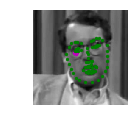

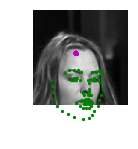

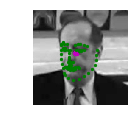

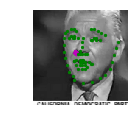

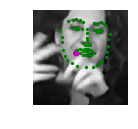

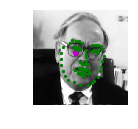

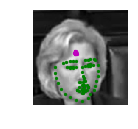

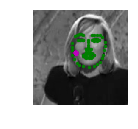

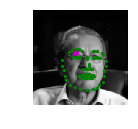

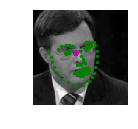

In [20]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [21]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()


optimizer =  optim.Adam(net.parameters(), lr = 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [22]:
def sample_batch_loss(sample):
    
    images = sample['image']
    images = images.type(torch.FloatTensor)

    key_pts = sample['keypoints']
    key_pts = key_pts.view(key_pts.size(0), -1)
    key_pts = key_pts.type(torch.FloatTensor)
    with torch.no_grad():
        output_pts = net(images)
        loss = criterion(output_pts, key_pts)
        return loss.item()

In [23]:
for test_batch in test_loader:
    saved_test_batch = test_batch
    break

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


In [24]:
#net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))
#print(sample_batch_loss(saved_test_batch))


In [25]:
#net.load_state_dict(torch.load('saved_models/keypoints_model_2.pt'))
print(sample_batch_loss(saved_test_batch))


0.24742719531059265


In [26]:
def train_net(n_epochs, optimizer):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {:0.6f}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0
                print('Test loss: {:0.6f}'.format(sample_batch_loss(saved_test_batch)))

    print('Finished Training')


In [27]:
# train your network
# optimizer =  optim.RMSprop(net.parameters(), lr = 0.001)
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Worksp0aces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs, optimizer)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.137270
Test loss: 0.092009
Epoch: 1, Batch: 20, Avg. Loss: 0.113649
Test loss: 0.085669
Epoch: 1, Batch: 30, Avg. Loss: 0.111290
Test loss: 0.087453
Epoch: 1, Batch: 40, Avg. Loss: 0.100034
Test loss: 0.100852
Epoch: 1, Batch: 50, Avg. Loss: 0.084172
Test loss: 0.078268
Epoch: 1, Batch: 60, Avg. Loss: 0.085656
Test loss: 0.079622
Epoch: 1, Batch: 70, Avg. Loss: 0.107340
Test loss: 0.077612
Epoch: 1, Batch: 80, Avg. Loss: 0.072795
Test loss: 0.085059
Epoch: 1, Batch: 90, Avg. Loss: 0.091348
Test loss: 0.074574
Epoch: 1, Batch: 100, Avg. Loss: 0.080219
Test loss: 0.087308
Epoch: 1, Batch: 110, Avg. Loss: 0.095820
Test loss: 0.074809
Epoch: 1, Batch: 120, Avg. Loss: 0.084908
Test loss: 0.080613
Epoch: 1, Batch: 130, Avg. Loss: 0.098927
Test loss: 0.075273
Epoch: 1, Batch: 140, Avg. Loss: 0.088493
Test loss: 0.073200
Epoch: 1, Batch: 150, Avg. Loss: 0.096064
Test loss: 0.073935
Epoch: 1, Batch: 160, Avg. Loss: 0.096151
Test loss: 0.068864
Epoch: 1, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.089510
Test loss: 0.062867
Epoch: 2, Batch: 20, Avg. Loss: 0.092518
Test loss: 0.073105
Epoch: 2, Batch: 30, Avg. Loss: 0.082072
Test loss: 0.050769
Epoch: 2, Batch: 40, Avg. Loss: 0.082166
Test loss: 0.055827
Epoch: 2, Batch: 50, Avg. Loss: 0.099899
Test loss: 0.048762
Epoch: 2, Batch: 60, Avg. Loss: 0.085319
Test loss: 0.050448
Epoch: 2, Batch: 70, Avg. Loss: 0.076949
Test loss: 0.060384
Epoch: 2, Batch: 80, Avg. Loss: 0.098386
Test loss: 0.061613
Epoch: 2, Batch: 90, Avg. Loss: 0.078730
Test loss: 0.050095
Epoch: 2, Batch: 100, Avg. Loss: 0.068544
Test loss: 0.060152
Epoch: 2, Batch: 110, Avg. Loss: 0.083703
Test loss: 0.056700
Epoch: 2, Batch: 120, Avg. Loss: 0.084928
Test loss: 0.071066
Epoch: 2, Batch: 130, Avg. Loss: 0.091297
Test loss: 0.045606
Epoch: 2, Batch: 140, Avg. Loss: 0.075086
Test loss: 0.049162
Epoch: 2, Batch: 150, Avg. Loss: 0.073465
Test loss: 0.056694
Epoch: 2, Batch: 160, Avg. Loss: 0.074418
Test loss: 0.049987
Epoch: 2, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.085226
Test loss: 0.038892
Epoch: 3, Batch: 20, Avg. Loss: 0.104653
Test loss: 0.060411
Epoch: 3, Batch: 30, Avg. Loss: 0.085728
Test loss: 0.055007
Epoch: 3, Batch: 40, Avg. Loss: 0.075211
Test loss: 0.060522
Epoch: 3, Batch: 50, Avg. Loss: 0.080734
Test loss: 0.060732
Epoch: 3, Batch: 60, Avg. Loss: 0.075965
Test loss: 0.061300
Epoch: 3, Batch: 70, Avg. Loss: 0.058296
Test loss: 0.057692
Epoch: 3, Batch: 80, Avg. Loss: 0.062710
Test loss: 0.050986
Epoch: 3, Batch: 90, Avg. Loss: 0.067881
Test loss: 0.053076
Epoch: 3, Batch: 100, Avg. Loss: 0.088280
Test loss: 0.046509
Epoch: 3, Batch: 110, Avg. Loss: 0.085790
Test loss: 0.063156
Epoch: 3, Batch: 120, Avg. Loss: 0.075821
Test loss: 0.049246
Epoch: 3, Batch: 130, Avg. Loss: 0.083797
Test loss: 0.053671
Epoch: 3, Batch: 140, Avg. Loss: 0.078597
Test loss: 0.046076
Epoch: 3, Batch: 150, Avg. Loss: 0.061446
Test loss: 0.036865
Epoch: 3, Batch: 160, Avg. Loss: 0.078385
Test loss: 0.082021
Epoch: 3, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.081857
Test loss: 0.051676
Epoch: 4, Batch: 20, Avg. Loss: 0.073756
Test loss: 0.052739
Epoch: 4, Batch: 30, Avg. Loss: 0.064168
Test loss: 0.056630
Epoch: 4, Batch: 40, Avg. Loss: 0.065782
Test loss: 0.063219
Epoch: 4, Batch: 50, Avg. Loss: 0.080439
Test loss: 0.064414
Epoch: 4, Batch: 60, Avg. Loss: 0.098847
Test loss: 0.055681
Epoch: 4, Batch: 70, Avg. Loss: 0.070790
Test loss: 0.053484
Epoch: 4, Batch: 80, Avg. Loss: 0.083454
Test loss: 0.043066
Epoch: 4, Batch: 90, Avg. Loss: 0.074823
Test loss: 0.045003
Epoch: 4, Batch: 100, Avg. Loss: 0.064740
Test loss: 0.053507
Epoch: 4, Batch: 110, Avg. Loss: 0.072593
Test loss: 0.051972
Epoch: 4, Batch: 120, Avg. Loss: 0.071115
Test loss: 0.045391
Epoch: 4, Batch: 130, Avg. Loss: 0.053279
Test loss: 0.050602
Epoch: 4, Batch: 140, Avg. Loss: 0.070358
Test loss: 0.040689
Epoch: 4, Batch: 150, Avg. Loss: 0.051242
Test loss: 0.043488
Epoch: 4, Batch: 160, Avg. Loss: 0.079709
Test loss: 0.061959
Epoch: 4, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.065290
Test loss: 0.053092
Epoch: 5, Batch: 20, Avg. Loss: 0.060604
Test loss: 0.060676
Epoch: 5, Batch: 30, Avg. Loss: 0.071999
Test loss: 0.049454
Epoch: 5, Batch: 40, Avg. Loss: 0.070186
Test loss: 0.045687
Epoch: 5, Batch: 50, Avg. Loss: 0.088941
Test loss: 0.046380
Epoch: 5, Batch: 60, Avg. Loss: 0.085098
Test loss: 0.056258
Epoch: 5, Batch: 70, Avg. Loss: 0.079548
Test loss: 0.054236
Epoch: 5, Batch: 80, Avg. Loss: 0.083734
Test loss: 0.047339
Epoch: 5, Batch: 90, Avg. Loss: 0.061591
Test loss: 0.040878
Epoch: 5, Batch: 100, Avg. Loss: 0.076277
Test loss: 0.046205
Epoch: 5, Batch: 110, Avg. Loss: 0.064586
Test loss: 0.049906
Epoch: 5, Batch: 120, Avg. Loss: 0.060316
Test loss: 0.052674
Epoch: 5, Batch: 130, Avg. Loss: 0.085354
Test loss: 0.050899
Epoch: 5, Batch: 140, Avg. Loss: 0.078875
Test loss: 0.050320
Epoch: 5, Batch: 150, Avg. Loss: 0.070976
Test loss: 0.043679
Epoch: 5, Batch: 160, Avg. Loss: 0.068573
Test loss: 0.045662
Epoch: 5, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.077523
Test loss: 0.047790
Epoch: 6, Batch: 20, Avg. Loss: 0.063772
Test loss: 0.046681
Epoch: 6, Batch: 30, Avg. Loss: 0.082622
Test loss: 0.047851
Epoch: 6, Batch: 40, Avg. Loss: 0.057773
Test loss: 0.054620
Epoch: 6, Batch: 50, Avg. Loss: 0.067509
Test loss: 0.059500
Epoch: 6, Batch: 60, Avg. Loss: 0.048132
Test loss: 0.045839
Epoch: 6, Batch: 70, Avg. Loss: 0.059511
Test loss: 0.050106
Epoch: 6, Batch: 80, Avg. Loss: 0.062737
Test loss: 0.048432
Epoch: 6, Batch: 90, Avg. Loss: 0.068831
Test loss: 0.058405
Epoch: 6, Batch: 100, Avg. Loss: 0.063091
Test loss: 0.056864
Epoch: 6, Batch: 110, Avg. Loss: 0.063671
Test loss: 0.052331
Epoch: 6, Batch: 120, Avg. Loss: 0.055507
Test loss: 0.050767
Epoch: 6, Batch: 130, Avg. Loss: 0.100387
Test loss: 0.051357
Epoch: 6, Batch: 140, Avg. Loss: 0.066520
Test loss: 0.051219
Epoch: 6, Batch: 150, Avg. Loss: 0.077268
Test loss: 0.049343
Epoch: 6, Batch: 160, Avg. Loss: 0.084295
Test loss: 0.051306
Epoch: 6, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.059961
Test loss: 0.047539
Epoch: 7, Batch: 20, Avg. Loss: 0.049606
Test loss: 0.050973
Epoch: 7, Batch: 30, Avg. Loss: 0.063493
Test loss: 0.045534
Epoch: 7, Batch: 40, Avg. Loss: 0.100069
Test loss: 0.045123
Epoch: 7, Batch: 50, Avg. Loss: 0.057866
Test loss: 0.048011
Epoch: 7, Batch: 60, Avg. Loss: 0.060834
Test loss: 0.054626
Epoch: 7, Batch: 70, Avg. Loss: 0.056508
Test loss: 0.045819
Epoch: 7, Batch: 80, Avg. Loss: 0.055645
Test loss: 0.050073
Epoch: 7, Batch: 90, Avg. Loss: 0.058687
Test loss: 0.043710
Epoch: 7, Batch: 100, Avg. Loss: 0.073881
Test loss: 0.055924
Epoch: 7, Batch: 110, Avg. Loss: 0.059890
Test loss: 0.043397
Epoch: 7, Batch: 120, Avg. Loss: 0.066696
Test loss: 0.067900
Epoch: 7, Batch: 130, Avg. Loss: 0.060057
Test loss: 0.042056
Epoch: 7, Batch: 140, Avg. Loss: 0.070516
Test loss: 0.046574
Epoch: 7, Batch: 150, Avg. Loss: 0.067340
Test loss: 0.039983
Epoch: 7, Batch: 160, Avg. Loss: 0.059109
Test loss: 0.044576
Epoch: 7, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.060275
Test loss: 0.056907
Epoch: 8, Batch: 20, Avg. Loss: 0.075156
Test loss: 0.034536
Epoch: 8, Batch: 30, Avg. Loss: 0.062929
Test loss: 0.032508
Epoch: 8, Batch: 40, Avg. Loss: 0.049277
Test loss: 0.024845
Epoch: 8, Batch: 50, Avg. Loss: 0.047842
Test loss: 0.029267
Epoch: 8, Batch: 60, Avg. Loss: 0.069265
Test loss: 0.035223
Epoch: 8, Batch: 70, Avg. Loss: 0.052948
Test loss: 0.037045
Epoch: 8, Batch: 80, Avg. Loss: 0.044665
Test loss: 0.037930
Epoch: 8, Batch: 90, Avg. Loss: 0.060094
Test loss: 0.028508
Epoch: 8, Batch: 100, Avg. Loss: 0.048496
Test loss: 0.030931
Epoch: 8, Batch: 110, Avg. Loss: 0.052438
Test loss: 0.026074
Epoch: 8, Batch: 120, Avg. Loss: 0.044933
Test loss: 0.031319
Epoch: 8, Batch: 130, Avg. Loss: 0.049341
Test loss: 0.023856
Epoch: 8, Batch: 140, Avg. Loss: 0.039265
Test loss: 0.020132
Epoch: 8, Batch: 150, Avg. Loss: 0.043753
Test loss: 0.021481
Epoch: 8, Batch: 160, Avg. Loss: 0.048991
Test loss: 0.026277
Epoch: 8, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.047505
Test loss: 0.043847
Epoch: 9, Batch: 20, Avg. Loss: 0.036418
Test loss: 0.025266
Epoch: 9, Batch: 30, Avg. Loss: 0.035936
Test loss: 0.018060
Epoch: 9, Batch: 40, Avg. Loss: 0.053596
Test loss: 0.015519
Epoch: 9, Batch: 50, Avg. Loss: 0.062737
Test loss: 0.015555
Epoch: 9, Batch: 60, Avg. Loss: 0.031532
Test loss: 0.028125
Epoch: 9, Batch: 70, Avg. Loss: 0.037790
Test loss: 0.020024
Epoch: 9, Batch: 80, Avg. Loss: 0.035565
Test loss: 0.017798
Epoch: 9, Batch: 90, Avg. Loss: 0.035485
Test loss: 0.020169
Epoch: 9, Batch: 100, Avg. Loss: 0.050229
Test loss: 0.018702
Epoch: 9, Batch: 110, Avg. Loss: 0.035420
Test loss: 0.021371
Epoch: 9, Batch: 120, Avg. Loss: 0.035892
Test loss: 0.030683
Epoch: 9, Batch: 130, Avg. Loss: 0.032197
Test loss: 0.012428
Epoch: 9, Batch: 140, Avg. Loss: 0.035976
Test loss: 0.020650
Epoch: 9, Batch: 150, Avg. Loss: 0.025439
Test loss: 0.019020
Epoch: 9, Batch: 160, Avg. Loss: 0.035525
Test loss: 0.023248
Epoch: 9, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.042723
Test loss: 0.021062
Epoch: 10, Batch: 20, Avg. Loss: 0.034439
Test loss: 0.018939
Epoch: 10, Batch: 30, Avg. Loss: 0.030122
Test loss: 0.020150
Epoch: 10, Batch: 40, Avg. Loss: 0.044775
Test loss: 0.023777
Epoch: 10, Batch: 50, Avg. Loss: 0.030085
Test loss: 0.026358
Epoch: 10, Batch: 60, Avg. Loss: 0.059412
Test loss: 0.018228
Epoch: 10, Batch: 70, Avg. Loss: 0.029025
Test loss: 0.018190
Epoch: 10, Batch: 80, Avg. Loss: 0.029473
Test loss: 0.019813
Epoch: 10, Batch: 90, Avg. Loss: 0.031009
Test loss: 0.020842
Epoch: 10, Batch: 100, Avg. Loss: 0.026071
Test loss: 0.022687
Epoch: 10, Batch: 110, Avg. Loss: 0.035701
Test loss: 0.018423
Epoch: 10, Batch: 120, Avg. Loss: 0.024675
Test loss: 0.017375
Epoch: 10, Batch: 130, Avg. Loss: 0.028914
Test loss: 0.016388
Epoch: 10, Batch: 140, Avg. Loss: 0.029689
Test loss: 0.018583
Epoch: 10, Batch: 150, Avg. Loss: 0.030028
Test loss: 0.020415
Epoch: 10, Batch: 160, Avg. Loss: 0.027368
Test loss: 0.018622
E

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [28]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


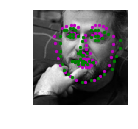

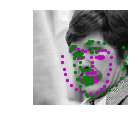

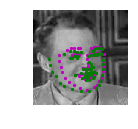

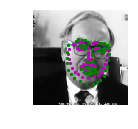

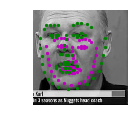

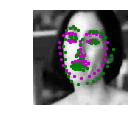

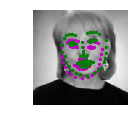

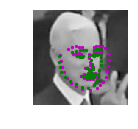

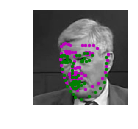

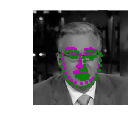

In [29]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [30]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_b_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

I chose Adam for optimization because, specially with convnets, it is becoming a de facto standard, achieving better results with better stability, and needing less learning rate trials/tunning.

Adam combines advantages of momentum and adaptive learning rate, being less sensitive to local minimum or too great/too small derivatives because it uses a moving mean of many gradients. 

Altough it is not the better option in all cases, many papers and researchs are using it. So I decided to start trying it.

For the loss, I chose SmoothL1Loss because it tends to be less sensitive to outliers, conveniently combining square error and L1 error. Looked more promising to me, since there are a lot of points to predict, and just one error on prediction or on labeling could make the learning instable.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I added simple convolutional layers with max pooling until the resulting feature maps/output image where small enough to be flattened. Since the images are simple and small, the database is relatively simple and small and the task is not so complicated, I decided to start with the simplest architecture.

In the first iteration, I made the traditional aproach of doubling the number of filters every downsampling, and only a single fully connected layer at the end. But when I visualized the conv layers filters output, almost all where doing litle transformation, and a few where doing the same line detection. So, I thinked that the features are not so dificult to detect, but I have to predict 63 simultaneous regresssions from these features. 

On that, I decided to try fewer filters on convnets, but more layers on fully connected side, to focus on the regression task of detecting many points. Also, some point detecteds tends to be somehow aligned/correlated with other points, so I saw that more fully connected layers could learn these relations.

The network with a simpler and smaller structure, but one more fc layer, reduced the loss by about 20% with same epochs and, specially on visualization, the points where much more aligned with ground truth.

Dropout layers were added to prevent overfitting

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I tried to increase batch_size but there was no memory available on the notebook.

About the epochs, since the loss is the primary measurement available, because we are doing regression, it was very dificult to answer the question: what is an ideal/baseline loss??

In classification, I could have used accuracy, precision, reccall, f-betascores, etc.

So, I decided to modify the code to include the loss of first test batch, to compare the learning curve of train and loss and see if both did not diverge too much, also seeing the oscilation between batchs of training data and comparing same batch loss between epochs.

These comparisons where had a little prejudice because I was using dropout, so I think the oscillation on the neurons dropped out was being captured too. Need to see how, while training, it is possible to deactivate dropout layers on the forward pass just to measure loss.

I stopped training on the 6th epoch, because the loss seen to be just oscilating and not decreasing anymore. In a real project, with time and resource available, it would be better to make more experimentations, visualizing the errors, comparing test and train loss on all data, saving a checkpoint, training a few more epochs with a lower learning rate, and then comparing again after a few more epochs, specially the train loss being much lower than test loss, wich would be a signal of overfitting so gains of train loss would not pay off. Visualizing the errors, specially on examples with largest loss, tend to be a good measure too, to detect were the model is having more dificult.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.16558306  0.14650431 -0.03144072 -0.19044712 -0.1269069 ]
 [ 0.09086823  0.0911319  -0.13513608 -0.04189748 -0.0352093 ]
 [-0.07345829  0.14580989 -0.04548625 -0.14054367 -0.21036522]
 [-0.11517095  0.07562383  0.06067441 -0.11353004  0.04291328]
 [-0.16279043 -0.12210919 -0.11240707 -0.0608744  -0.14604612]]
(5, 5)


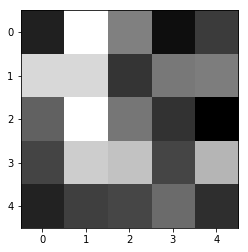

In [31]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

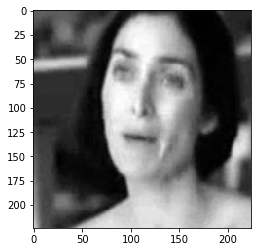

In [32]:
##TODO: load in and display any image from the transformed test dataset
image = test_images[5].data
image = image.numpy()   # convert to numpy array from a Tensor
image = np.squeeze(np.transpose(image, (1, 2, 0)))
plt.imshow(image, cmap='gray')

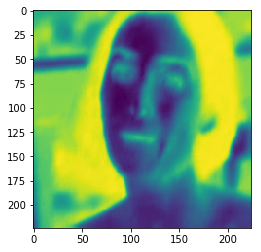

In [33]:
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2
output = cv2.filter2D(image, -1, w[filter_index][0])
plt.imshow(output)

In [34]:
def visualize_weigths(weights, filter:int, channel=0):
    output = cv2.filter2D(image, -1, weights[filter][channel])
    plt.imshow(output, cmap='gray')


In [35]:
w1 = net.conv1.weight.data.numpy()
w2 = net.conv2.weight.data.numpy()
w3 = net.conv3.weight.data.numpy()
w4 = net.conv4.weight.data.numpy()
w5 = net.conv5.weight.data.numpy()


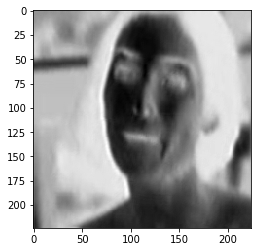

In [36]:
visualize_weigths(w1, 2)

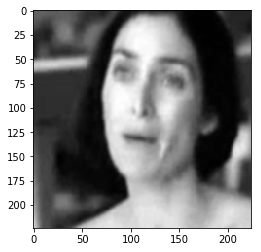

In [37]:
visualize_weigths(w2, 40)

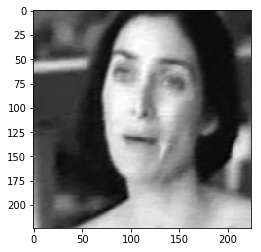

In [38]:
visualize_weigths(w3, 10)

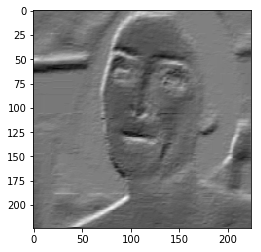

In [39]:
visualize_weigths(w4, 60)

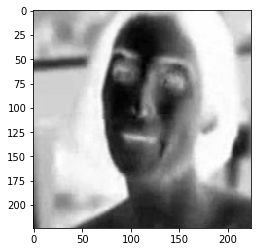

In [40]:
visualize_weigths(w5, 0)

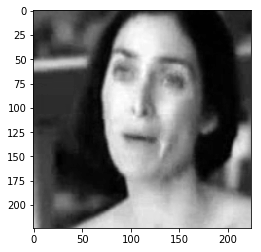

In [41]:
visualize_weigths(w5, 20)

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: 

Aparently, the filters on the convolutional nets are focusing on large vertical lines and on abrupt change of colors (like beggining/enc of hair, eyebrows, etc)

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!